In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


<ipython-input-69-b613ec75818c>:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_rng = pd.date_range(start='2024-01-01', periods=200, freq='H')  # 200 hourly data points


Dataset size: 200


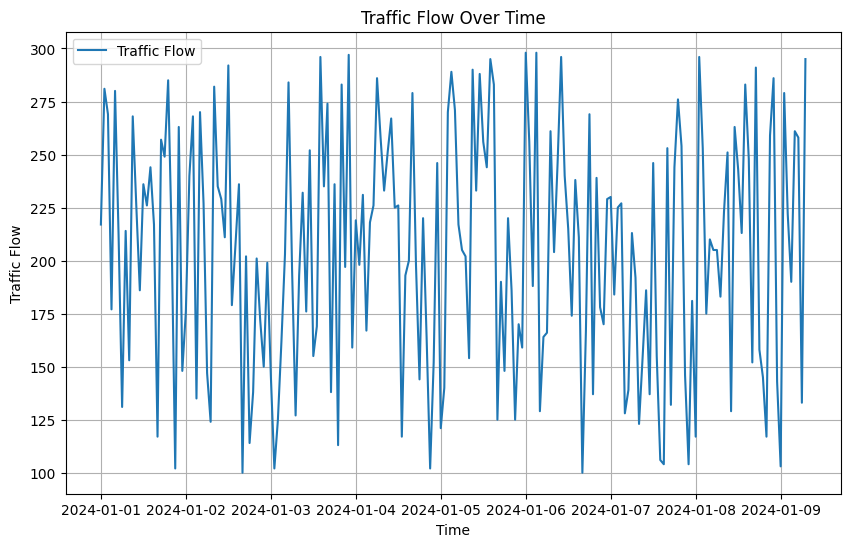

In [69]:
# Generate synthetic dataset if real dataset is too small
date_rng = pd.date_range(start='2024-01-01', periods=200, freq='H')  # 200 hourly data points
synthetic_data = pd.DataFrame(date_rng, columns=['timestamp'])
synthetic_data['traffic_flow'] = np.random.randint(100, 300, size=(len(date_rng)))

# Use synthetic dataset
data = synthetic_data.set_index('timestamp')
print(f"Dataset size: {len(data)}")

# Visualize the dataset
plt.figure(figsize=(10, 6))
plt.plot(data['traffic_flow'], label='Traffic Flow')
plt.title('Traffic Flow Over Time')
plt.xlabel('Time')
plt.ylabel('Traffic Flow')
plt.legend()
plt.grid()
plt.show()


In [70]:
# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[['traffic_flow']])


In [71]:
# Function to create sequences
def create_sequences(data, sequence_length):
    if len(data) <= sequence_length:
        raise ValueError(f"Not enough data points to create sequences. "
                         f"Dataset size: {len(data)}, sequence_length: {sequence_length}")
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Adjust sequence length
sequence_length = 12  # Experiment with different values like 6, 12, or 24
print(f"Adjusted sequence length: {sequence_length}")

# Create sequences
try:
    X, y = create_sequences(data_scaled, sequence_length)
    print(f"Generated sequences: X shape: {X.shape}, y shape: {y.shape}")
except ValueError as e:
    print(e)
    raise ValueError("Dataset is too small for the chosen sequence length.")


Adjusted sequence length: 12
Generated sequences: X shape: (188, 12, 1), y shape: (188, 1)


In [72]:
# Split into training and testing sets
train_size = max(1, int(0.8 * len(X)))  # At least one sample for training
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Ensure training and testing sets are not empty
if len(X_train) == 0 or len(X_test) == 0:
    raise ValueError("Training or testing set is empty. Ensure the dataset is sufficiently large or reduce sequence length.")

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

# Reshape inputs for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"Training data shape: {X_train.shape}, Testing data shape: {X_test.shape}")


Training samples: 150, Testing samples: 38
Training data shape: (150, 12, 1), Testing data shape: (38, 12, 1)


In [73]:
# Build LSTM model
def build_model(input_shape):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),  # Increased units
        Dropout(0.3),  # Add dropout to prevent overfitting
        LSTM(64, return_sequences=False),
        Dropout(0.3),
        Dense(1)  # Output layer
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Create the model
model = build_model((sequence_length, 1))
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                       │ (None, 12, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 12, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 116,033 (453.25 KB)

 Trainable params: 116,033 (453.25 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
from tensorflow.keras.callbacks import EarlyStopping

# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Dynamically adjust batch size
batch_size = max(1, min(32, len(X_train)))  # Ensure batch size is valid
epochs = 50  # Increase epochs to allow better learning

print(f"Adjusted batch size: {batch_size}")

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],  # Use early stopping
    verbose=1
)



Adjusted batch size: 32
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - loss: 0.2618 - val_loss: 0.1066
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0982 - val_loss: 0.1031
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0839 - val_loss: 0.1160
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0819 - val_loss: 0.1123
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0901 - val_loss: 0.1012
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0819 - val_loss: 0.1002
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0843 - val_loss: 0.1040
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0800 - val_loss: 0.1088
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0878 - val_loss: 0.1011
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0830 - val_loss: 0.0997
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0860 - val_loss: 0.1032
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.

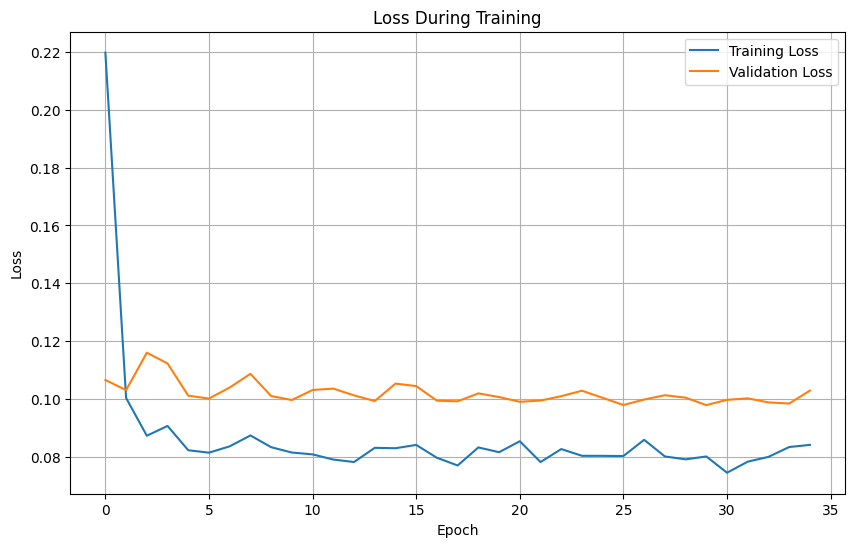

In [75]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step
Mean Absolute Error (MAE): 54.37
Root Mean Squared Error (RMSE): 61.97


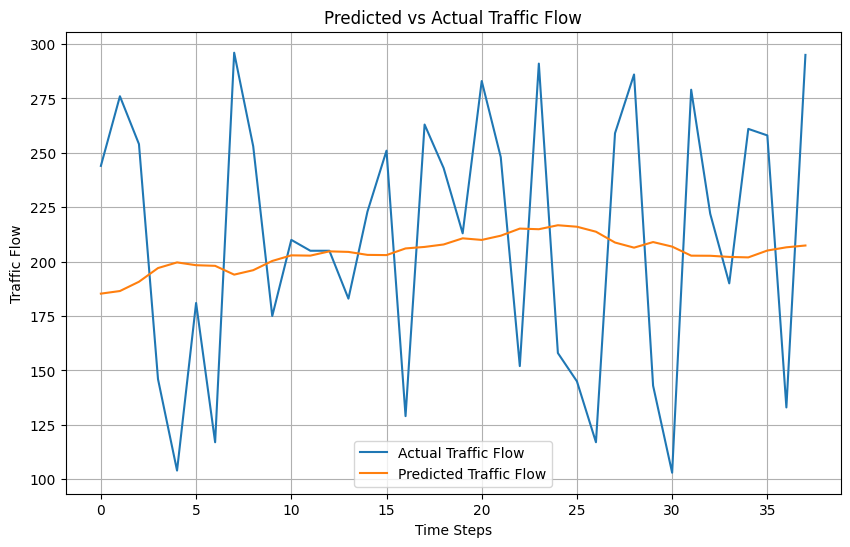

In [76]:
# Predict on test data
y_pred = model.predict(X_test)

# Rescale predictions and true values back to original scale
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

# Evaluate model performance
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Plot predictions vs actual values over more test samples
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled[:50], label='Actual Traffic Flow')  # Plot more points
plt.plot(y_pred_rescaled[:50], label='Predicted Traffic Flow')
plt.title('Predicted vs Actual Traffic Flow')
plt.xlabel('Time Steps')
plt.ylabel('Traffic Flow')
plt.legend()
plt.grid()
plt.show()
